In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import importlib

from astroLuSt.physics import asteroseismology
from astroLuSt.physics import photometry as alpp
from astroLuSt.synthetics import images as alsi

importlib.reload(asteroseismology)
importlib.reload(alpp)
importlib.reload(alsi)

<module 'astroLuSt.synthetics.images' from 'c:\\Users\\lukas\\Documents\\GitHub\\astroLuSt\\demos\\..\\astroLuSt\\synthetics\\images.py'>

# Magnitudes and Fluxes

In [2]:
m = 10
m_ref = 5
f_ref = 2
d = 20 #pc
plx = 1/d #arcsec

## Converting Magnitudes and Fluxes

In [3]:
f = alpp.mags2fluxes(m=m, m_ref=m_ref, f_ref=5)
print(f'Flux from mags: {f}')
m = alpp.fluxes2mags(f=f, f_ref=f_ref, m_ref=m_ref)
print(f'Mag from fluxes: {m} mag')

Flux from mags: 0.05
Mag from fluxes: 9.005149978319906 mag


## Distance Modulus

In [4]:
DM = alpp.DistanceModule(m=m, M=None, d=d, plx=None)

print(DM)



DistanceModule(
    m=9.005149978319906, M=7.5,
    d=20, plx=0.05,
)


## Converting to Wesenheit Magnitude

In [5]:
W = alpp.wesenheit_magnitude(M=DM.M, CI=0.3, R=0)
print(f'Wesenheit Magnitude: {W} mag')

Wesenheit Magnitude: 7.5 mag


## Adding Magnitudes and Estimating Target Star Contribution

### Generate some "stars" on a "sky background" (driven by fluxes)

c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\physics\photometry.py:298: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(f/f_ref) + m_ref


TPF(
    size=(100, 100),
    mode='flux',
    f_ref=1, m_ref=0,
    store_stars=True,
    verbose=0,
)


c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\synthetics\images.py:552: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend in ['lineary', 'linearx']:


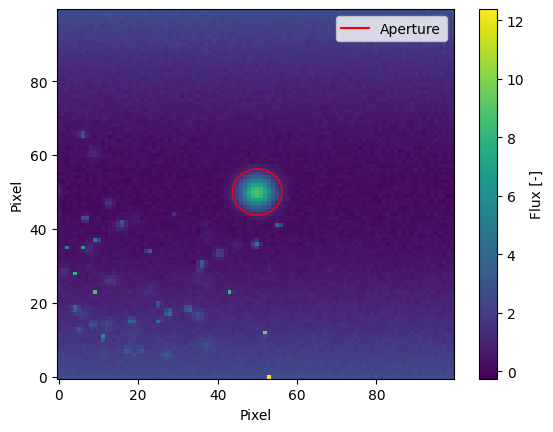

Estimated Aperture: 10


In [279]:
importlib.reload(alsi)

TPF = alsi.TPF(
    size=100,
    mode='flux',
    # mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng=None,
    verbose=0,
)
print(TPF)

#random stars (distribution specified via dict)
TPF.add_stars(
    nstars=100,
    posx={'dist':'normal', 'params':{'loc':20, 'scale':20}},
    posy={'dist':'normal', 'params':{'loc':20, 'scale':20}},
    f={'dist':'uniform', 'params':{'low':1,'high':10}},
    # m={'dist':'uniform', 'params':{'low':-4,'high':4}},
    aperture={'dist':'poisson', 'params':{'lam':2}},
)
#specified stars
TPF.add_stars(
    nstars=1,
    posx=np.array([50]),
    posy=np.array([50]),
    f=np.array([500]),
    m=None,
    aperture=np.array([10]),
)
#custom (quadratic) trend
TPF.add_custom(np.linspace(-50,np.ones((100))*50,100)**2, amplitude=1E-3)

#noise
TPF.add_noise(amplitude=1E-1, bias=1E-1)

#plot (including last aperture)
fig, axs = TPF.plot_result(plot_apertures=[-1])
plt.show()

#estimate aperture
try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,2]):.0f}')
except:
    pass

### Generate some "stars" on a "sky background" (driven by magnitudes)

TPF(
    size=(100, 100),
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    verbose=0,
)
Estimated Aperture: 10
[ 50.          50.         630.95734448  -7.          10.        ]


c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\synthetics\images.py:555: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend == 'linearx':


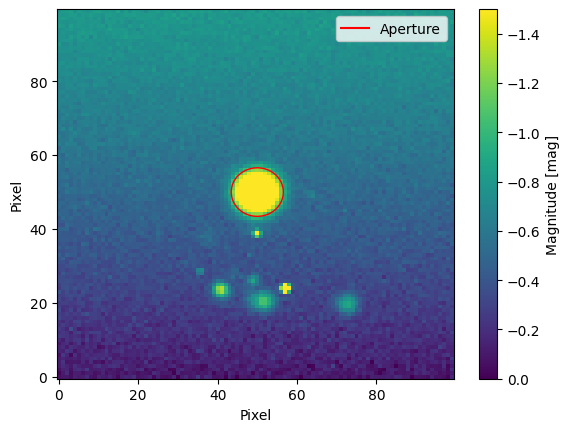

In [280]:
importlib.reload(alsi)

TPF = alsi.TPF(
    size=100,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng=None,
    verbose=0
)
print(TPF)


#random stars (distribution specified via list)
TPF.add_stars(
    nstars=30,
    posx={'dist':'chisquare', 'params':[50]},
    posy={'dist':'chisquare', 'params':[30]},
    # f={'dist':'uniform', 'params':[1,10]},
    m={'dist':'uniform', 'params':[-4,4]},
    aperture={'dist':'poisson', 'params':[5]},
)
#specified stars
TPF.add_stars(
    nstars=1,
    posx=np.array([50]),
    posy=np.array([50]),
    # f=np.array([500]),
    m=np.array([-7]),
    aperture=np.array([10]),
)

#custom (linear) trend
TPF.add_custom('lineary', amplitude=1)

#noise
TPF.add_noise(amplitude=5E-2, bias=1E-1)


#plot (including multiple apertures)
# fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1))
fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1), pcolormesh_kwargs=dict(vmin=-1.5, vmax=0))

try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,2]):.0f}')
except:
    pass
print(TPF.starparams[-1])

### Calculating total magnitude of all contaminants
* Weighted by distance to target star

In [281]:
#get target and contaminants
targ = TPF.starparams[-1]
cont = TPF.starparams[:-1]

#calculate distances
cont_pos = cont[:,:2]
dists = np.sqrt(np.sum((cont_pos - targ[:2])**2, axis=1))

#generate weights via distances
w = dists/dists.max()   #normalize distances to a max of

#calculate total magnitude of contaminants
cont_m = np.array([c[2] for c in cont])
m_tot = alpp.mags_sum(m=cont_m, w=w)
print(f'Total magnitude of contaminants: {m_tot:.5f} mag')


Total magnitude of contaminants: -2.29652 mag


### Calculate fractional contribution of target star

In [282]:

m_cont_pre = alpp.mags_contribution(m=targ[3], m_cont=m_tot)       #using calculated total magnitude
m_cont_fly = alpp.mags_contribution(m=targ[3], m_cont=cont_m, w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (precalculated): {m_cont_pre:.3f}')
print(f'Contribution of Target (on the fly):    {m_cont_fly:.3f}')


Contribution of Target (precalculated): 0.987
Contribution of Target (on the fly):    0.987


## Generating Movies of Stars on Silicon

c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\physics\photometry.py:298: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(f/f_ref) + m_ref
c:\Users\lukas\Documents\GitHub\astroLuSt\demos\..\astroLuSt\physics\photometry.py:298: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(f/f_ref) + m_ref
MovieWriter ffmpeg unavailable; using Pillow instead.


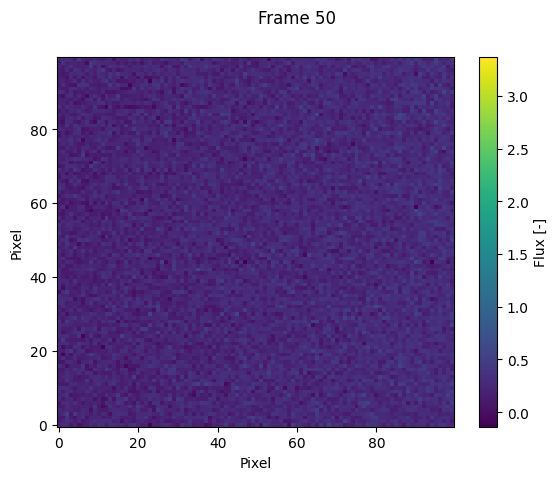

TPF_Series(

)



In [298]:
%matplotlib inline
importlib.reload(alsi)

times = np.linspace(-100,100,50)*np.pi
TPFS = alsi.TPF_Series(
    size=100,
    mode='flux',
    # mode='mag',
    f_ref=1, m_ref=0,
    rng=None,
    verbose=0    
)

TPFS.make_frames(
    times=times,
    add_stars_kwargs=dict(
        nstars=30,
        posx    ={'dist':'uniform', 'params':[1, 100]},
        posy    ={'dist':'uniform', 'params':[1, 100]},
        f       ={'dist':'uniform', 'params':[1, 40]},
        m       ={'dist':'uniform', 'params':[-4,4]},
        aperture={'dist':'uniform', 'params':[4, 10]},
    ),
    add_noise_kwargs=dict(amplitude=1E-1, bias=1E-1),
    add_custom_kwargs=dict(trend='linearx', amplitude=1E-1),
)

TPFS.plot_result(
    save='./test.gif'
    # pcolormesh_kwargs=dict(vmin=100, vmax=250),
)

print(TPFS)

# Asteroseismic Scaling Relations

See for example [Gaulme et al., (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...832..121G/abstract) and references therein.

In [ ]:
SR = asteroseismology.ScalingRelations(
    nu_max  =np.array([3100,  1573, 1354]),
    delta_nu=np.array([135.2, 80.62, 73.22]),
    t_eff   =np.array([5777,  6433, 5645]),
    e_nu_max=np.array([np.nan, 11, 30]),
    e_delta_nu=np.array([np.nan, 1.88, 2.13]),
    e_t_eff=np.array([np.nan, 80, 80]),
    zeta_corr=False
)
print(SR)

mass = SR.get_mass()
radius = SR.get_radius()
logg = SR.get_logg()
logL = SR.get_luminosity()

df = SR.results2pandas()

df